In [1]:
import h5py, os

import numpy as np
import matplotlib

from matplotlib.patches import Circle
%matplotlib inline

import ecog
from ecog.utils.electrodes import load_electrode_labels
from ecog.signal_processing import hilbert_transform, gaussian
from ecog.tokenize.transcripts import parse, make_df
from ecog.utils import bands
from ecog.signal_processing import zscore

In [1]:
import h5py, os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from ecog.utils.electrodes import load_electrode_labels
from ecog.tokenize.transcripts import parse, make_df
from ecog.signal_processing import zscore

import analysis
from analysis import make_slice, make_colors, make_bracket

In [2]:
subj_path = os.path.join(os.environ['HOME'], 'Development/data/ecog/EC2')
block = 'EC2_B1'
block_path = os.path.join(subj_path, block)
rate = 400

anatomy = load_electrode_labels(subj_path)
vsmc_idxs = np.array([idx for idx, a in enumerate(anatomy) if a in ['preCG', 'postCG']])

ec2_b1_transcript_parse = parse(block_path, block)
ec2_b1_transcript = make_df(ec2_b1_transcript_parse, 1, 'EC2', 1)

idx = (ec2_b1_transcript['label'] == 'raa').argmax()

sl = make_slice(idx, ec2_b1_transcript, rate)

In [3]:
with h5py.File(os.path.join(block_path, 'ecog400/ecog.h5')) as f:
    raw_vsmc_data = f['ecogDS/data'][sorted(vsmc_idxs)]
vsmc_data, means, stds = zscore(raw_vsmc_data, mode='file', sampling_freq=400., block_path=block_path)
baa_data = vsmc_data[:, sl]

# Electrodes by time

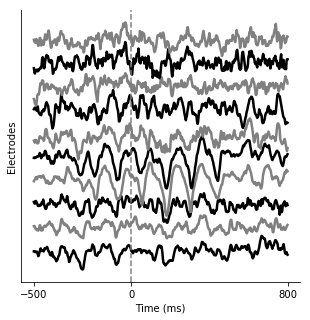

In [4]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_electrodes_by_time(baa_data[15:25], ax)
plt.savefig('/home/jesse/Downloads/electrodes.pdf')

# Bandpassed electrode

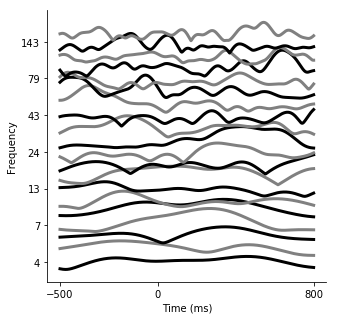

In [5]:
elec_idx = 19
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 2)

plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_40bands_by_time(elec_data, band_idxs, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/frequencies.pdf')

# Neuro bands

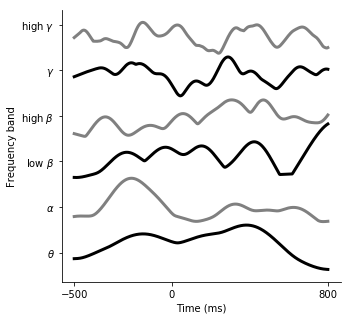

In [6]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_neurobands_by_time(elec_data, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/bands.pdf')

# Dataset

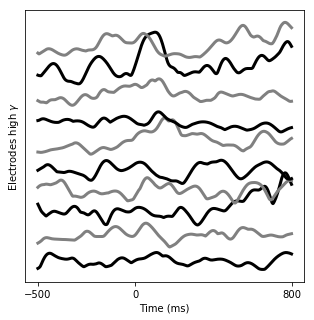

In [7]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_datapoints(vsmc_data[15:25], [sl], rate, block_path, [ax])
plt.savefig('/home/jesse/Downloads/data.pdf')

# Network

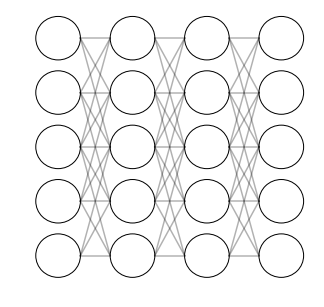

In [8]:
plt.close()
figsize = (5, 5)
f, ax = plt.subplots(1, figsize=figsize)
analysis.plot_network(5, 4, ax)
#plt.savefig('/home/jesse/Downloads/bands.pdf')

# Normal pipeline

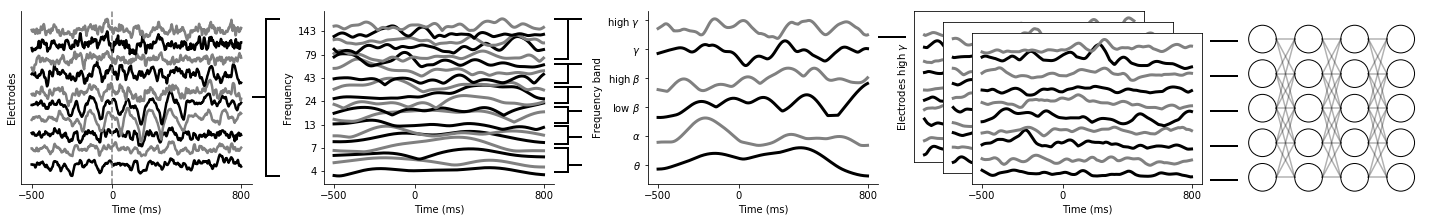

In [10]:
figsize = (20, 3)
x2y = figsize[0] / figsize[1]
f = plt.figure(figsize=figsize)

height = .8
width_square = height / x2y

width = .16

ax0 = f.add_axes([.02, .15, width, height])
ax1 = f.add_axes([.23, .15, width, height])
ax2 = f.add_axes([.455, .15, width, height])
n_data = 3
data_axes = [f.add_axes([.64+(ii*.02), .25-(ii*.05), width, .7]) for ii in range(n_data)]
axn = f.add_axes([.87, .1, width_square, height])

analysis.plot_electrodes_by_time(baa_data[15:25], ax0)
analysis.plot_40bands_by_time(elec_data, band_idxs, sl, rate, block_path, ax1)
analysis.plot_neurobands_by_time(elec_data, sl, rate, block_path, ax2)
analysis.plot_datapoints(vsmc_data[15:25], [make_slice(idx, ec2_b1_transcript, rate) for idx in [2, 23, 131]],
                         rate, block_path, data_axes)
analysis.plot_network(5, 4, axn)

bax0 = f.add_axes([.18, .15, .02, height])
make_bracket([.5], [0, 1], bax0)

bax1_t = f.add_axes([.39, .2, .02, .12])
make_bracket([0, 1], [.3], bax1_t)
bax1_a = f.add_axes([.39, .33, .02, .09])
make_bracket([0, 1], [.4], bax1_a)
bax1_lb = f.add_axes([.39, .43, .02, .08])
make_bracket([0, 1], [.75], bax1_lb)
bax1_hb = f.add_axes([.39, .52, .02, .08])
make_bracket([0, 1], [1], bax1_hb)
bax1_g = f.add_axes([.39, .61, .02, .1])
make_bracket([0, 1], [1], bax1_g)
bax1_hg = f.add_axes([.39, .72, .02, .2])
make_bracket([0, 1], [1], bax1_hg)

ax_select = f.add_axes([.615, .15, .02, height])
y = .85
ax_select.plot([0, 1], [y, y], 'k', lw=2)
ax_select.set_ylim(0, 1)
ax_select.axis('off')

ax_data = f.add_axes([.845, .15, .02, height])
for y in np.linspace(.02, .825, 5):
    ax_data.plot([0, 1], [y, y], 'k', lw=2)
ax_data.set_ylim(0, 1)
ax_data.axis('off')

plt.savefig('/home/jesse/Downloads/normal_pipeline.png')